# SYDE556/750 Assignment 3: Connecting Neurons

- Due Date: March 3rd
- Total marks: 10 (10% of final grade)
- Late penalty: 1 mark per day

- It is recommended that you use a language with a matrix library and graphing capabilities.  Two main suggestions are Python and MATLAB.
- *Do not use any code from Nengo*

In [5]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['font.size'] = 24

Populating the interactive namespace from numpy and matplotlib


In [18]:
class LIF_neuron():

    def __init__(self,e,alpha,Jbias,tau_ref,tau_rc):
        self.e=e
        self.tau_ref=tau_ref
        self.tau_rc=tau_rc
        self.Jbias=Jbias
        self.alpha=alpha
        self.V=0.0
        self.dVdt=0.0
        self.stimulus=[]
        self.spikes=[]
        self.Vhistory=[]

    def set_sample_rates(self,x_vals):
        self.sample_x=x_vals
        self.sample_rates=[]
        for x in x_vals:
            J=self.alpha*np.dot(x,self.e)+self.Jbias
            if J>1:
                rate=1/(self.tau_ref-self.tau_rc*np.log(1-1/J))
            else:
                rate=0
            self.sample_rates.append(float(rate))
        return self.sample_rates

    def set_sample_rates_noisy(self,x_vals,noise,rng):
        self.sample_x=x_vals
        self.sample_rates_noisy=[]
        for x in x_vals:
            eta=0
            J=self.alpha*np.dot(x,self.e)+self.Jbias
            if J>1:
                rate=1/(self.tau_ref -self.tau_rc*np.log(1-1/J))
            else:
                rate=0
            if noise !=0:
                eta=rng.normal(loc=0,scale=noise)
            self.sample_rates_noisy.append(float(rate+eta))
        return self.sample_rates_noisy

    def set_spikes(self,stimulus,T,dt):
        self.stimulus=stimulus #an array
        self.spikes=[]
        self.Vhistory=[]
        ref_window=int(self.tau_ref/dt) #number of timesteps in refractory period
        for t in range(len(stimulus)):
            self.J=self.alpha*np.dot(self.stimulus[t],self.e) + self.Jbias
            self.dVdt=((1/self.tau_rc)*(self.J-self.V))
            #check if there have been spikes in the last tau_rc seconds
            for h in range(ref_window):   
                if len(self.spikes) >= ref_window and self.spikes[-(h+1)] == 1:
                    self.dVdt=0     #if so, voltage isn't allowed to change
            #Euler's Method Approximation V(t+1) = V(t) + dt *dV(t)/dt
            self.V=self.V+dt*self.dVdt  
            if self.V >= 1.0:
                self.spikes.append(1)   #a spike
                self.V=0.0    #reset
            else:
                self.spikes.append(0)   #not a spike
                if self.V < 0.0: self.V=0.0
            self.Vhistory.append(self.V)
    def get_sample_rates(self):
        return self.sample_rates

    def get_sample_rates_noisy(self):
        return self.sample_rates_noisy

    def get_spikes(self):
        return self.spikes

def ensemble(n_neurons,x_min,x_max,dx,a_min,a_max,
                seed,tau_ref,tau_rc,noise,T,dt,stimulus):

    #create sample points
    rng1=np.random.RandomState(seed=seed) #for neuron parameters
    a_max_array=rng1.uniform(a_min,a_max,n_neurons)
    x_int_array=rng1.uniform(x_min,x_max,n_neurons)
    e_array=-1+2*rng1.randint(2,size=n_neurons)
    x_sample=np.vstack(np.arange(x_min,x_max,dx))

    #create neurons, rate neurons for decoders, spiking neurons for estimate
    neurons=[]
    spikes=[]
    for i in range(n_neurons):
        alpha=1/(np.dot(x_max,1)-np.dot(x_int_array[i],1))*\
                (-1+1/(1-np.exp((tau_ref-1/a_max_array[i])/tau_rc)))
        Jbias=1-alpha*np.dot(x_int_array[i],1)
        n=LIF_neuron(e_array[i],alpha,Jbias,tau_ref,tau_rc)
        n.set_sample_rates(x_sample)
        n.set_sample_rates_noisy(x_sample,noise,rng1)
        n.set_spikes(stimulus,T,dt)
        neurons.append(n)
        spikes.append(n.get_spikes())

    return neurons, spikes

def ensemble_2D(n_neurons,x_min,x_max,dx,a_min,a_max,
                seed,tau_ref,tau_rc,noise,T,dt,stimulus):

    dimension=2
    rng1=np.random.RandomState(seed=seed) #for neuron parameters
    a_max_array=rng1.uniform(a_min,a_max,n_neurons)

    #generate encoders over an n-dimensional hypersphere (not evenly distributed)
    angles=rng1.uniform(0,2*np.pi,n_neurons)     
    e_array=np.array([(np.cos(angles)[i],np.sin(angles)[i]) 
                    for i in range(len(angles))]) #on unit circle

    #create sample points
    x_int_array=np.array([rng1.uniform(x_min,x_max)*e_array[i]
                    for i in range(len(e_array))])  #along encoders

    x1 = np.arange(x_min, x_max, dx)
    x2 = np.arange(x_min, x_max, dx)
    x_mesh=np.vstack(np.meshgrid(x1, x2)).reshape(2,-1).T

    #create neurons, rate neurons for decoders, spiking neurons for estimate
    neurons=[]
    spikes=[]
    for i in range(n_neurons):
        #assume e=[1...1] (len dimensions) when calculating alpha, Jbias
        x_max_D=np.full((dimension),x_max)
        x_max_dot_1=np.dot(x_max_D,np.full((dimension),1))/dimension
        x_int_dot_1=np.dot(x_int_array[i],np.full((dimension),1))/dimension
        alpha=1/(x_max_dot_1-x_int_dot_1)*\
                (-1+1/(1-np.exp((tau_ref-1/a_max_array[i])/tau_rc)))
        Jbias=1-alpha*x_int_dot_1
        n=LIF_neuron(e_array[i],alpha,Jbias,tau_ref,tau_rc)
        n.set_sample_rates(x_mesh)
        n.set_sample_rates_noisy(x_mesh,noise,rng1)
        n.set_spikes(stimulus,T,dt)
        neurons.append(n)
        spikes.append(n.get_spikes())

    return neurons, spikes

def generate_signal(T,dt,rms,limit,rng,distribution='uniform'):

    #first generate X(w), with the specified constraints,
    #then use an inverse fft to get x_t
    t=np.arange(int(T/dt))*dt
    delta_w = 2*np.pi/T #omega stepsize
    w_vals = np.arange(-len(t)/2,0,delta_w) #make half of X(w), those with negative freq
    w_limit=2*np.pi*limit #frequency in radians
    bandwidth=2*np.pi*limit #bandwidth in radians
    x_w_half1=[]
    x_w_half2=[]

    for i in range(len(w_vals)):    #loop over frequency values
        if distribution=='uniform':
            #if |w| is within the specified limit, generate a coefficient
            if abs(w_vals[i]) < w_limit:    
                x_w_i_real = rng.normal(loc=0,scale=1)  #mean=0, sigma=1
                x_w_i_im = rng.normal(loc=0,scale=1)
                x_w_half1.append(x_w_i_real + 1j*x_w_i_im)
                #make the 2nd half of X(w) with complex conjugates
                x_w_half2.append(x_w_i_real - 1j*x_w_i_im)  

        elif distribution=='gaussian':
            #draw sigma from a gaussian distribution
            sigma=np.exp(-np.square(w_vals[i])/(2*np.square(bandwidth)))
            if sigma > np.finfo(float).eps: #distinguishable from zero
                x_w_i_real = rng.normal(loc=0,scale=sigma)
                x_w_i_im = rng.normal(loc=0,scale=sigma)  
                x_w_half1.append(x_w_i_real + 1j*x_w_i_im)
                x_w_half2.append(x_w_i_real - 1j*x_w_i_im)  

    #zero pad the positive and negative amplitude lists, so each is len(samples/2)
    x_w_pos=np.hstack((x_w_half2[::-1],np.zeros(len(t)/2-len(x_w_half2))))
    x_w_neg=np.hstack((np.zeros(len(t)/2-len(x_w_half1)),x_w_half1))
    #assemble the symmetric X(w) according to numpy.fft documentation
    #amplitudes corresponding to [w_0, w_pos increasing, w_neg increasing]
    x_w=np.hstack(([0+0j],x_w_pos,x_w_neg))
    x_t=np.fft.ifft(x_w)
    #normalize time and frequency signals using RMS
    true_rms=np.sqrt(dt/T*np.sum(np.square(x_t)))   
    x_t = x_t*rms/true_rms
    #return real part of signal to avoid warning
    x_t = x_t.real.reshape(len(x_t),1)
    x_w = x_w*rms/true_rms

    return x_t, x_w  

def get_rate_decoders(neurons,noise,function=lambda x: x):

    A_T=[]
    for n in neurons:
        A_T.append(n.get_sample_rates())
    A_T=np.matrix(A_T)
    A=np.transpose(A_T)
    x=np.matrix(neurons[0].sample_x) #use x_sample, not x_t, to define rates
    upsilon=A_T*function(x)/len(x)
    gamma=A_T*A/len(x) + np.identity(len(neurons))*noise**2
    d=np.linalg.inv(gamma)*upsilon
    return d

def get_spike_decoders(spikes,h,function=lambda x: x):

    A_T=np.array([np.convolve(s,h,mode='full')[:len(spikes[0])] for s in spikes])
    A=np.matrix(A_T).T
    x=np.matrix(neurons[0].sample_x)
    upsilon=A_T*function(x)/len(x)
    gamma=A_T*A/len(x)
    d=np.linalg.pinv(gamma)*upsilon
    return d

def get_rate_estimate(neurons,d,noise):

    xhat=[]
    for j in range(len(neurons[0].sample_x)):
        xhat_i=0
        for i in range(len(neurons)):
            if noise != 0:
                a_ij=neurons[i].get_sample_rates_noisy()[j]
                d_i=np.array(d[i])
                xhat_i+=(a_ij*d_i).flatten()
            else:
                a_ij=neurons[i].get_sample_rates()[j]
                d_i=np.array(d[i])
                xhat_i+=(a_ij*d_i).flatten()
        xhat.append(xhat_i)
    xhat=np.array(xhat)
    return xhat

def get_spike_estimate(spikes,h,d):

    timesteps=len(spikes[0])
    dimension=d[0].shape[1]
    n_neurons=len(d)
    xhat=np.zeros((timesteps,dimension))
    for i in range(n_neurons):
        decoder=d[i]
        filtered_spikes=np.convolve(spikes[i],h,mode='full')\
            [:timesteps].reshape(timesteps,1)
        value=filtered_spikes*decoder
        xhat+=value

    return xhat

## 1) Decoding from a population

As you did in previous assignments, make a population of 20 LIF neurons representing a 1-dimensional value, and compute a decoder for them.  For parameters, $\tau_{ref}$=0.002s, $\tau_{RC}$=0.02s, the maximum firing rates are chosen randomly from a uniform distribution between 100 and 200Hz (at the max radius), and the x-intercepts are chosen randomly from a uniform distribution between -2 and 2.  Remember that the $\alpha$ and $J^{bias}$ terms are computed based on these x-intercepts and maximum firing rates.

It is generally easiest to compute decoders using the original method from Assignment 1, where we use the rate-mode approximation for the neurons to generate the $A$ matrix, then find $\Gamma=A^T A + \sigma^2 I$.  You can use this approach to find decoders, and these decoders should work even when you simulate the neurons in terms of spikes (in question 2 on).  The only difference will be that they will need to be scaled by ``dt``, your simulation time step.

You can use this same method for computing decoders for this whole assignment.

#### [0.5 marks] Plot the tuning curves (firing rate of each neuron for different $x$ values between -2 and 2)</li>

#### [0.5 marks] Compute the decoders and plot $(x-\hat{x})$.  When computing decoders, take into account noise($\sigma$=0.1 times 200Hz).  When computing $\hat{x}$, add random gaussian noise with $\\sigma$=0.1 times 200Hz to the activity. Report the Root Mean-Squared Error (RMSE).

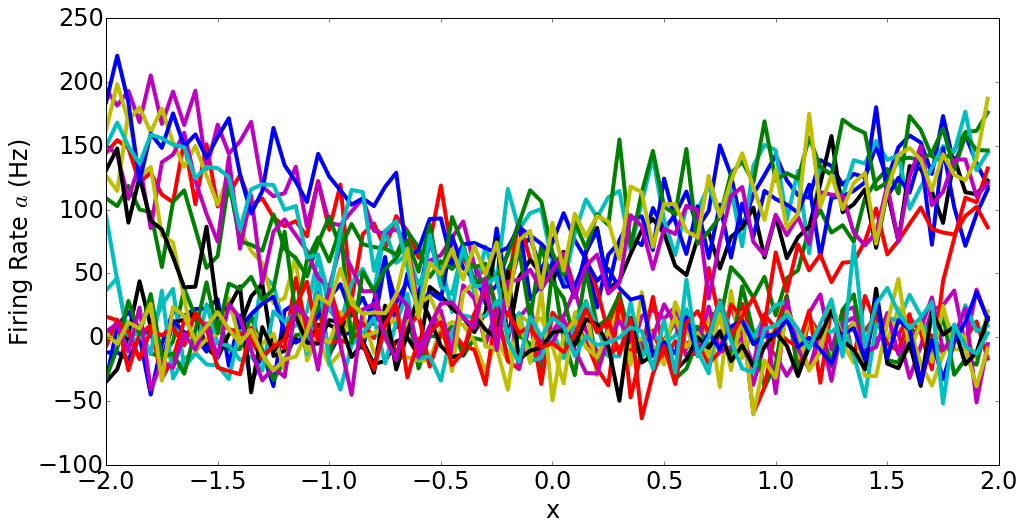

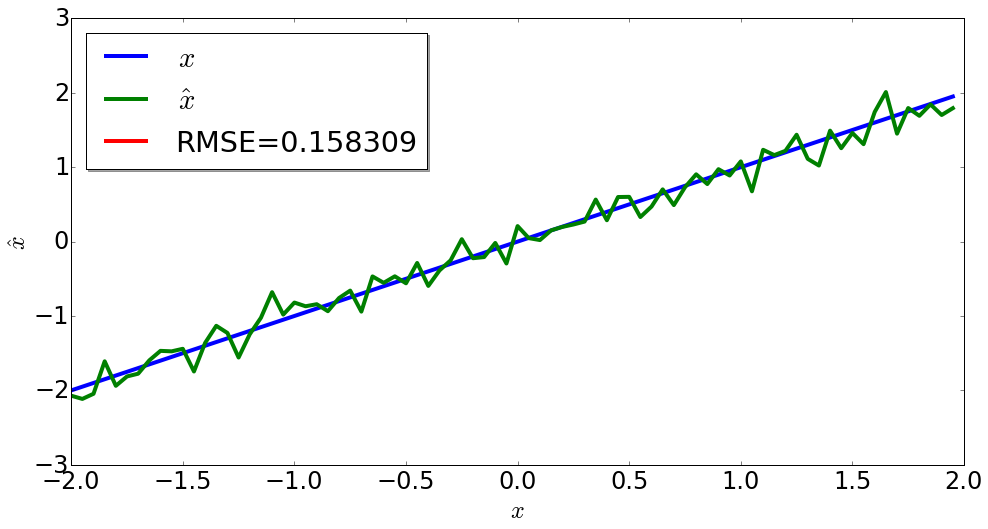

In [19]:
def one():

	#LIF parameters
    n_neurons=20
    a_min=100
    a_max=200
    x_min=-2
    x_max=2
    dx=0.05
    tau_ref=0.002
    tau_rc=0.02
    seed=3
    T=1.0
    dt=0.001
    t=np.arange(int(T/dt)+1)*dt
    stimulus=np.zeros(len(t))
    noise=0.1*a_max

    neurons, spikes = ensemble(n_neurons,x_min,x_max,dx,a_min,a_max,seed,
            tau_ref,tau_rc,noise,T,dt,stimulus)

    #plot tuning curves
    x_sample=neurons[0].sample_x
    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    for n in neurons:
        y=n.get_sample_rates_noisy()
        ax.plot(x_sample,y)
    ax.set_xlim(x_min,x_max)
    ax.set_xlabel('x')
    ax.set_ylabel('Firing Rate $a$ (Hz)')
    plt.show()

    #compute decoders and state estimate
    d=get_rate_decoders(neurons,noise)
    xhat=get_rate_estimate(neurons,d,noise)

    #plot signal and estimate
    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.plot(x_sample,x_sample,label='$x$')
    ax.plot(x_sample,xhat,label='$\hat{x}$')
    ax.plot([],label='RMSE=%f' %np.sqrt(np.average((x_sample-xhat)**2)))
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\hat{x}$')
    legend=ax.legend(loc='best',shadow=True)
    plt.show()

one()

## 2) Decoding from two spiking neurons

Choose a neuron from part 1 that has a firing rate of somewhere between 20-50Hz for $x$=0.  Using that neuron's $\alpha$ and $J^{bias}$ value, construct two neurons: both with the same $\alpha$ and $J^{bias}$, but one with $e$=+1 and the other with $e$=-1.  With the function from the last assignment, generate a random input $x(t)$ that is 1 second long, with rms=1, dt=0.001, and an upper limit of 5Hz.  Feed that signal into the two neurons and generate spikes.  Decode the spikes back into $\hat{x}(t)$ using a post-synaptic current filter $h(t)$ with a time constant of $\tau$=0.005.

#### [0.5 marks] Plot the post-synaptic current $h(t)=e^{-t/\tau}/ \int e^{-t/\tau} dt$

#### [0.5 marks] Plot the original signal $x(t)$, the spikes, and the decoded $\hat{x}(t)$ all on the same graph

#### [0.5 marks] Compute the RMSE of the decoding

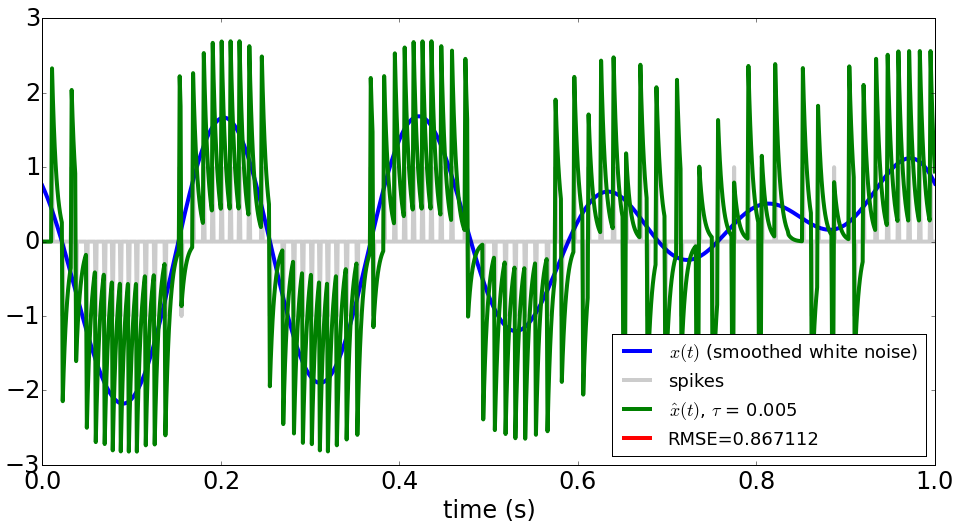

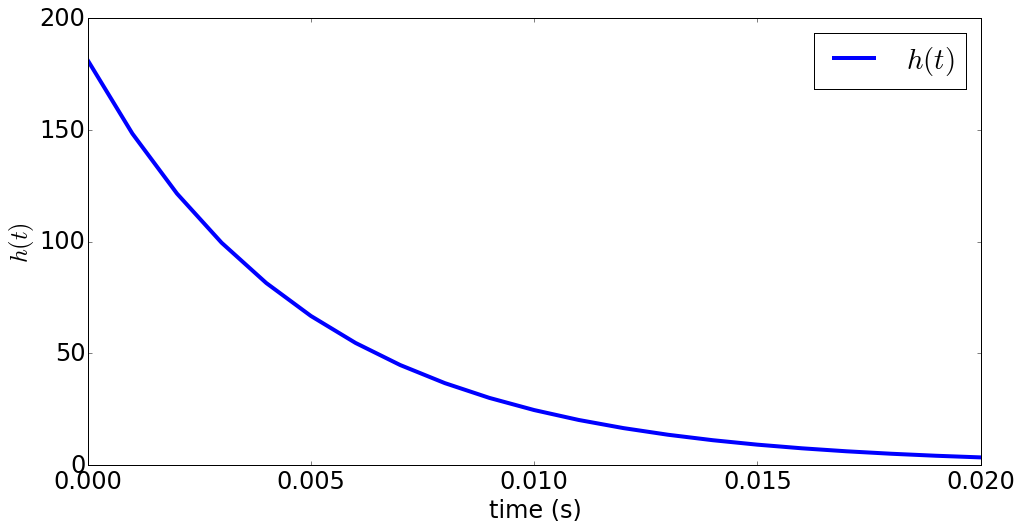

In [20]:
def two():

    #LIF parameters
    n_neurons=20
    a_min=100
    a_max=200
    x_min=-2
    x_max=2
    dx=0.05
    tau_ref=0.002
    tau_rc=0.02
    seed=3
    T=1.0
    dt=0.001
    t=np.arange(int(T/dt)+1)*dt
    stimulus=np.zeros(len(t))
    noise=0.1*a_max

    #find alpha and Jbias parameters
    neurons, spikes = ensemble(n_neurons,x_min,x_max,dx,a_min,a_max,seed,
            tau_ref,tau_rc,noise,T,dt,stimulus)
    x_sample=neurons[0].sample_x
    for n in neurons:
        if 20 < n.get_sample_rates_noisy()[len(x_sample)/2] < 50:
            alpha_chosen=n.alpha
            Jbias_chosen=n.Jbias
            break

    e1=1
    e2=-1
    T=1
    dt=0.001
    rms=1
    limit=5
    n=0

    #create neurons with chosen parameters
    rng1=np.random.RandomState(seed=seed)
    n1=LIF_neuron(e1,alpha_chosen,Jbias_chosen,tau_ref,tau_rc)
    n1.set_sample_rates(x_sample)
    n1.set_sample_rates_noisy(x_sample,noise,rng1)
    n2=LIF_neuron(e2,alpha_chosen,Jbias_chosen,tau_ref,tau_rc)
    n2.set_sample_rates(x_sample)
    n2.set_sample_rates_noisy(x_sample,noise,rng1)
    neurons=[n1,n2]

    #generate white noise signal
    rng2=np.random.RandomState(seed=seed) #for white noise signal
    x_t, x_w = generate_signal(T,dt,rms,limit,rng2,'uniform')
    stimulus = np.array(x_t)
    n1.set_spikes(stimulus,T,dt)
    n2.set_spikes(stimulus,T,dt)
    spikes1=n1.get_spikes()
    spikes2=n2.get_spikes()
    spikes=np.array([spikes1,spikes2])

    #set post-synaptic current temporal filter
    tau_synapse=0.005          
    h=t**n*np.exp(-t/tau_synapse)
    h=h/np.sum(h*dt)  #normalize, effectively scaling spikes by dt

    #calculate decoders using rate prodecure and filtered state estimate
    d=get_rate_decoders(neurons,noise)
    xhat=get_spike_estimate(spikes,h,d)

    #plot signal, spikes, and estimate
    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.plot(t,x_t, label='$x(t)$ (smoothed white noise)')
    ax.plot(t,(spikes[0]-spikes[1]), color='k', label='spikes', alpha=0.2)
    ax.plot(t,xhat, label='$\hat{x}(t)$, $\\tau$ = %s' %tau_synapse)
    ax.plot([],label='RMSE=%f' %np.sqrt(np.average((x_t-xhat)**2)))
    ax.set_xlabel('time (s)')
    legend=ax.legend(loc='best',fontsize=18) 
    plt.show()

    #plot filter
    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.plot(t,h, label='$h(t)$')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('$h(t)$')
    ax.set_xlim(0,0.02)
    legend=ax.legend(loc='best') 
    plt.show()
    
two()

## 3) Decoding from many neurons

Repeat question 2, but with more neurons.  Instead of picking particular neurons, randomly generate them with x-intercepts uniformly distributed between -2 and 2 and with maximum firing rates between 100 and 200 Hz.  Randomly choose encoder values to be either -1 or +1.

#### [2 marks] Plot Root Mean-Squared Error as the number of neurons increases.  Try 8 neurons, 16 neurons, 32, 64, 128, up to 256.  For the RMSE for a particular number of neurons, average over at least 5 randomly generated groups of neurons.  For each group of neurons, randomly generate the signal $x(t)$.  Use the same parameters as in question 2. Note: the RMSE should go down as the number of neurons increases

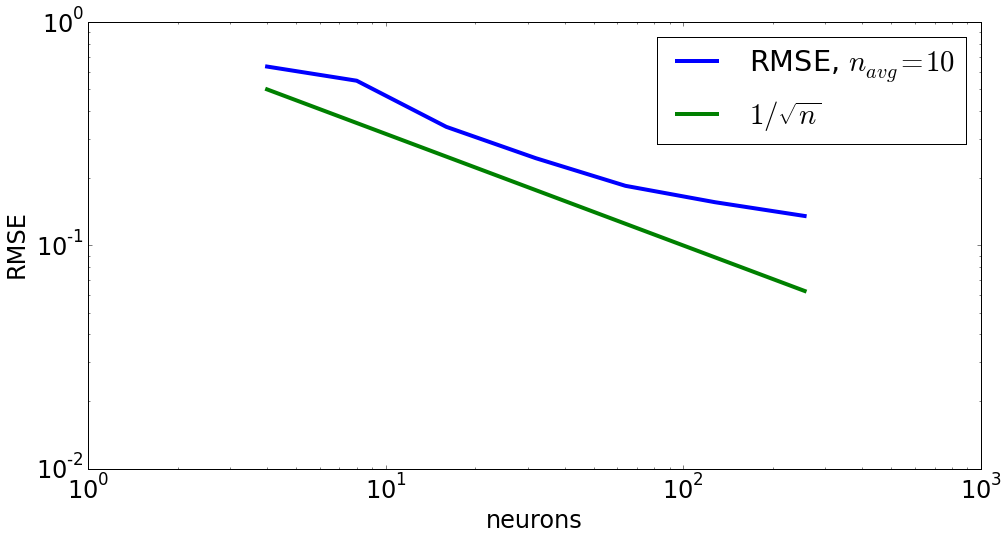

In [9]:
#takes a long time to run

def three():

    #parameters
    a_min=100
    a_max=200
    x_min=-2
    x_max=2
    dx=0.05
    tau_ref=0.002
    tau_rc=0.02
    T=1
    dt=0.001
    rms=1
    limit=5
    n=0
    avg=10
    t=np.arange(int(T/dt)+1)*dt
    noise=0.1*a_max

    #set post-synaptic current temporal filter
    tau_synapse=0.005          
    h=t**n*np.exp(-t/tau_synapse)
    h=h/np.sum(h*dt)  #normalize, effectively scaling spikes by dt

    n_neuron_list=[4,8,16,32,64,128,256]
    RMSE_list=[]

    for n in range(len(n_neuron_list)):
        n_neurons=n_neuron_list[n]
        RMSE_n=[]
        
        for a in range(avg):
            seed_neuron=n*avg+a
            seed_signal=n*3*a

            #generate white noise signal
            rng2=np.random.RandomState(seed=seed_signal) #for white noise signal
            x_t, x_w = generate_signal(T,dt,rms,limit,rng2,'uniform')

            neurons, spikes = ensemble(n_neurons,x_min,x_max,dx,a_min,a_max,seed_neuron,
                    tau_ref,tau_rc,noise,T,dt,stimulus=x_t)

            #calculate decoders using rate prodecure and filtered state estimate
            d=get_rate_decoders(neurons,noise)
            xhat=get_spike_estimate(spikes,h,d)

            #calculate RMSE
            RMSE_n_a=np.sqrt(np.average((x_t-xhat)**2))
            RMSE_n.append(RMSE_n_a)

        RMSE_list.append(np.average(RMSE_n))

    #plot RMSE vs n_neurons
    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.loglog(n_neuron_list,RMSE_list, label='RMSE, $n_{avg}=%s$' %avg)
    ax.loglog(n_neuron_list,1/np.sqrt(n_neuron_list), label='$1/\sqrt{n}$')
    ax.set_xlabel('neurons')
    ax.set_ylabel('RMSE')
    legend=ax.legend(loc='best') 
    plt.show()
    
three()

## 4) Connecting two groups of neurons

For this question, use two groups of neurons with intercepts between [-1, 1] to compute $y = 2x+1$.  The first group of neurons will represent $x$ and the second group will represent $y$.

Start by computing decoders.  You will need two decoders: one to decode $f(x)=2x+1$ from the first population, and one to decode $f(y)=y$ (the standard representational decoder) from the second population.  Remember that $\Upsilon$ changes depending on what function you want to decode.

Use the same neuron parameters as for previous questions, and use 200 randomly generated neurons in each population.

#### [1 mark] Show the behaviour of the system with an input of $x(t)=t-1$ for 1 second (a linear ramp from -1 to 0).  Plot the ideal $x(t)$ and $y(t)$ values, along with $\hat{y}(t)$.</li>
<ul>
<li>Note that you should use the decoders that work for any input over the range of intercepts: do not re-compute decoders for any particular input (i.e. set of $x$ values).</li>
<li>Input $x(t)$ into the first group of neurons and produce spikes.  Decode from those spikes using the decoder for $f(x)=2x+1$.  Input that decoded result into the second group of neurons to produce spikes.  Use the second decoder ($f(y)=y$) to decode $\hat{y}(t)$.</li>
</ul>
<p>

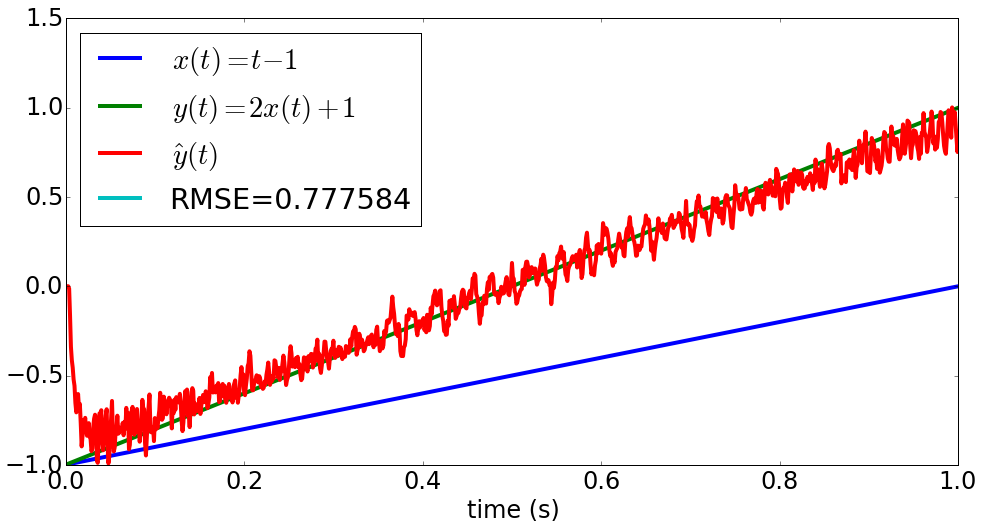

In [21]:
def four_a():

    #parameters
    n_neurons=200
    a_min=100
    a_max=200
    x_min=-1
    x_max=1
    dx=0.05
    tau_ref=0.002
    tau_rc=0.02
    T=1
    dt=0.001
    n=0
    noise=0.1*a_max

    #generate linear ramp signal x(t)=t-1
    t=np.arange(int(T/dt)+1)*dt
    x_t=t-1
    y_t=2*x_t+1

    #set post-synaptic current temporal filter
    tau_synapse=0.005          
    h=t**n*np.exp(-t/tau_synapse)
    h=h/np.sum(h*dt)  #normalize, effectively scaling spikes by dt

    #create first ensemble
    seed_neuron=3
    neurons_1, spikes_1 = ensemble(n_neurons,x_min,x_max,dx,a_min,a_max,seed_neuron,
            tau_ref,tau_rc,noise,T,dt,stimulus=x_t)

    #calculate decoders for f(x)=2x+1
    function_1=lambda x: 2*x + 1
    d_1=get_rate_decoders(neurons_1,noise,function_1)
    f_xhat=get_spike_estimate(spikes_1,h,d_1)

    #create second ensemble
    seed_neuron=9
    neurons_2, spikes_2 = ensemble(n_neurons,x_min,x_max,dx,a_min,a_max,seed_neuron,
            tau_ref,tau_rc,noise,T,dt,stimulus=f_xhat)

    #calculate decoders for f(y)=y
    function_2=lambda y: y
    d_2=get_rate_decoders(neurons_2,noise,function_2)
    f_yhat=get_spike_estimate(spikes_2,h,d_2)

    #plot signal, transformed signal, and estimate
    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.plot(t,x_t, label='$x(t)=t-1$')
    ax.plot(t,y_t, label='$y(t)=2x(t)+1$')
    ax.plot(t,f_yhat, label='$\hat{y}(t)$')
    ax.plot([],label='RMSE=%f' %np.sqrt(np.average((y_t-f_yhat)**2)))
    ax.set_xlabel('time (s)')
    legend=ax.legend(loc='best') 
    plt.show()
    
four_a()

#### [0.5 marks] Repeat part (a) with an input that is ten randomly chosen values between -1 and 0, each one held for 0.1 seconds (a randomly varying step input)

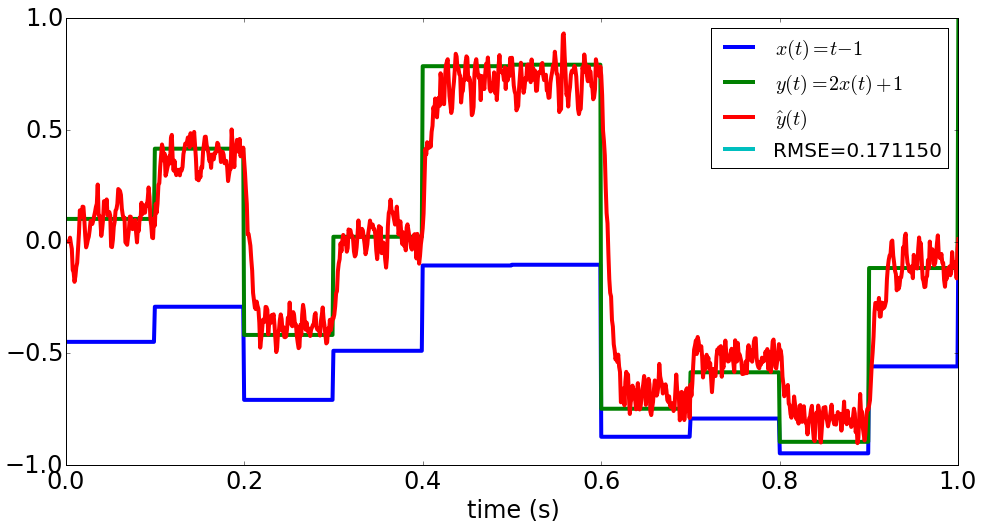

In [11]:
def four_b():

    #parameters
    n_neurons=200
    a_min=100
    a_max=200
    x_min=-1
    x_max=1
    dx=0.05
    tau_ref=0.002
    tau_rc=0.02
    T=1
    dt=0.001
    n=0
    noise=0.1*a_max

    #generate a randomly varying step signal
    seed_signal=3
    rng2=np.random.RandomState(seed=seed_signal)
    t=np.arange(int(T/dt)+1)*dt
    x_t=np.array([np.full((len(t)/10),rng2.rand()-1) for i in range(10)]).flatten()
    x_t=np.insert(x_t,len(x_t),0).reshape(len(t),1) #1001 time points
    y_t=2*x_t+1
 
    #set post-synaptic current temporal filter
    tau_synapse=0.005          
    h=t**n*np.exp(-t/tau_synapse)
    h=h/np.sum(h*dt)  #normalize, effectively scaling spikes by dt

    #create first ensemble
    seed_neuron=3
    neurons_1, spikes_1 = ensemble(n_neurons,x_min,x_max,dx,a_min,a_max,seed_neuron,
            tau_ref,tau_rc,noise,T,dt,stimulus=x_t)

    #calculate decoders for f(x)=2x+1
    function_1=lambda x: 2*x + 1
    d_1=get_rate_decoders(neurons_1,noise,function_1)
    f_xhat=get_spike_estimate(spikes_1,h,d_1)

    #create second ensemble
    seed_neuron=9
    neurons_2, spikes_2 = ensemble(n_neurons,x_min,x_max,dx,a_min,a_max,seed_neuron,
            tau_ref,tau_rc,noise,T,dt,stimulus=f_xhat)

    #calculate decoders for f(y)=y
    function_2=lambda y: y
    d_2=get_rate_decoders(neurons_2,noise,function_2)
    f_yhat=get_spike_estimate(spikes_2,h,d_2)

    #plot signal, transformed signal, and estimate
    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.plot(t,x_t, label='$x(t)=t-1$')
    ax.plot(t,y_t, label='$y(t)=2x(t)+1$')
    ax.plot(t,f_yhat, label='$\hat{y}(t)$')
    ax.plot([],label='RMSE=%f' %np.sqrt(np.average((y_t-f_yhat)**2)))
    ax.set_xlabel('time (s)')
    legend=ax.legend(loc='best',fontsize=20) 
    plt.show()
    
four_b()

#### [0.5 marks] Repeat part (a) with an input that is $x(t)=0.2sin(6\pi t)$. Briefly discuss the results for this question.

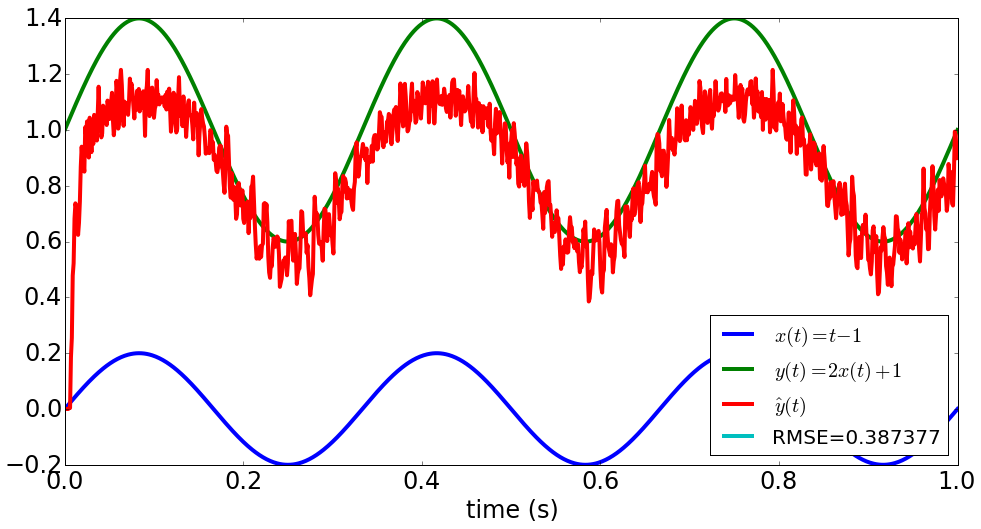

In [12]:
def four_c():

    #parameters
    n_neurons=200
    a_min=100
    a_max=200
    x_min=-1
    x_max=1
    dx=0.05
    tau_ref=0.002
    tau_rc=0.02
    T=1
    dt=0.001
    n=0
    noise=0.1*a_max

    #generate a sinusoid
    t=np.arange(int(T/dt)+1)*dt
    x_t=0.2*np.sin(6*np.pi*t)
    y_t=2*x_t+1
 
    #set post-synaptic current temporal filter
    tau_synapse=0.005          
    h=t**n*np.exp(-t/tau_synapse)
    h=h/np.sum(h*dt)  #normalize, effectively scaling spikes by dt

    #create first ensemble
    seed_neuron=3
    neurons_1, spikes_1 = ensemble(n_neurons,x_min,x_max,dx,a_min,a_max,seed_neuron,
            tau_ref,tau_rc,noise,T,dt,stimulus=x_t)

    #calculate decoders for f(x)=2x+1
    function_1=lambda x: 2*x + 1
    d_1=get_rate_decoders(neurons_1,noise,function_1)
    f_xhat=get_spike_estimate(spikes_1,h,d_1)

    #create second ensemble
    seed_neuron=9
    neurons_2, spikes_2 = ensemble(n_neurons,x_min,x_max,dx,a_min,a_max,seed_neuron,
            tau_ref,tau_rc,noise,T,dt,stimulus=f_xhat)

    #calculate decoders for f(y)=y
    function_2=lambda y: y
    d_2=get_rate_decoders(neurons_2,noise,function_2)
    f_yhat=get_spike_estimate(spikes_2,h,d_2)

    #plot signal, transformed signal, and estimate
    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.plot(t,x_t, label='$x(t)=t-1$')
    ax.plot(t,y_t, label='$y(t)=2x(t)+1$')
    ax.plot(t,f_yhat, label='$\hat{y}(t)$')
    ax.plot([],label='RMSE=%f' %np.sqrt(np.average((y_t-f_yhat)**2)))
    ax.set_xlabel('time (s)')
    legend=ax.legend(loc='lower right',fontsize=20) 
    plt.show()
    
four_c()

### Discussion

The estimate $\hat{y}(t)$ incurs error from the signal for two reasons. First, a delay is introduced by the synaptic filter $h(t)$ with magnitude proportional to the post-synaptic time constant $\tau=0.005$. Second, the decoded signal underestimates the shifted sinusoid. This is caused by neuron saturation: the maximum value that can be faithfully represented by a neuron is $x_{max}=1$. Beyond this value, the tuning curves of the neurons begin to flatten out, leading to diminishing returns in activity as $x(t)$ increases. This limits the entries in the activities matrix $A$, which in turn limits the decoders $d$ and the magnitude of the final estimate $\hat{y}(t)$ to a value near $1$. Unshifting the sinusoid with $y=2x(t)$ reduces the RMSE dramatically.

## 5) Connecting three groups of neurons

For this question, use three groups of neurons with intercepts from [-1, 1] to compute $z = 2y+0.5x$.  Follow the same steps as question 4, but take the decoded outputs from the first two groups of neurons ($f(y)=2y$ and $f(x)=0.5x$), add them together, and feed that into the third group of neurons.

#### [1 mark] Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for an input of $x(t)=cos(3\pi t)$ and $y(t)=0.5 sin (2 \pi t)$ (over 1.0 seconds)

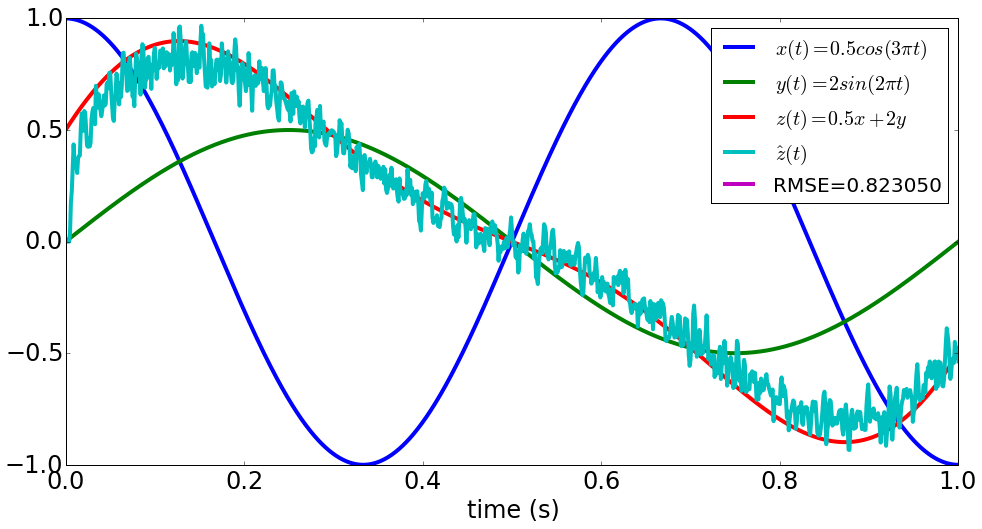

In [13]:
def five_a():

    #parameters
    n_neurons=200
    a_min=100
    a_max=200
    x_min=-1
    x_max=1
    dx=0.05
    tau_ref=0.002
    tau_rc=0.02
    T=1
    dt=0.001
    n=0
    noise=0.1*a_max

    #generate the sinusoidal signals x(t) and y(t)
    t=np.arange(int(T/dt)+1)*dt
    x_t=np.cos(3*np.pi*t)
    y_t=0.5*np.sin(2*np.pi*t)
    z_t=0.5*x_t+2*y_t

    #set post-synaptic current temporal filter
    tau_synapse=0.005          
    h=t**n*np.exp(-t/tau_synapse)
    h=h/np.sum(h*dt)

    #create first ensemble and calculate transformational decoders
    seed_neuron=3
    neurons_1, spikes_1 = ensemble(n_neurons,x_min,x_max,dx,a_min,a_max,seed_neuron,
            tau_ref,tau_rc,noise,T,dt,stimulus=x_t)
    function_1=lambda x: 0.5*x
    d_1=get_rate_decoders(neurons_1,noise,function_1)
    f_xhat=get_spike_estimate(spikes_1,h,d_1)

    #create second ensemble and calculate transformational decoders
    seed_neuron=9
    neurons_2, spikes_2 = ensemble(n_neurons,x_min,x_max,dx,a_min,a_max,seed_neuron,
            tau_ref,tau_rc,noise,T,dt,stimulus=y_t)
    function_2=lambda y: 2*y
    d_2=get_rate_decoders(neurons_2,noise,function_2)
    f_yhat=get_spike_estimate(spikes_2,h,d_2)

    #create third ensemble and calculate transformational decoders
    seed_neuron=9
    neurons_3, spikes_3 = ensemble(n_neurons,x_min,x_max,dx,a_min,a_max,seed_neuron,
            tau_ref,tau_rc,noise,T,dt,stimulus=f_xhat+f_yhat)
    function_3=lambda z: z
    d_3=get_rate_decoders(neurons_3,noise,function_3)
    f_zhat=get_spike_estimate(spikes_3,h,d_3)

    #plot signal, transformed signal, and estimate
    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.plot(t,x_t, label='$x(t)=0.5cos(3\pi t)$')
    ax.plot(t,y_t, label='$y(t)=2sin(2\pi t)$')
    ax.plot(t,z_t, label='$z(t)=0.5x+2y$')
    ax.plot(t,f_zhat, label='$\hat{z}(t)$')
    ax.plot([],label='RMSE=%f' %np.sqrt(np.average((z_t-f_zhat)**2)))
    ax.set_xlabel('time (s)')
    legend=ax.legend(loc='best',fontsize=20) 
    plt.show()

five_a()

#### [0.5 marks] Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for a random input over 1 second.  For $x(t)$ use a random signal with a limit of 8 Hz and `rms`=1.  For $y(t)$ use a random signal with a limit of 5 Hz and `rms`=0.5.

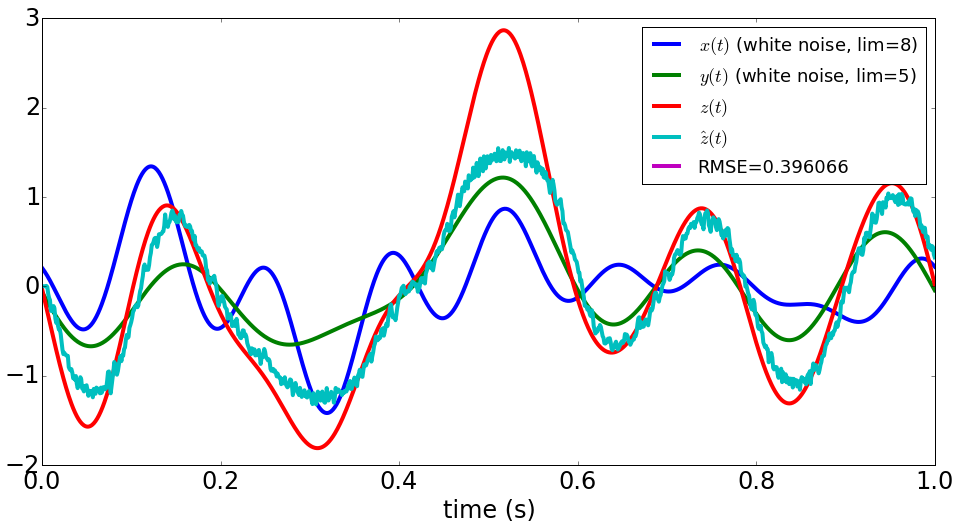

In [14]:
def five_b():

    #parameters
    n_neurons=200
    a_min=100
    a_max=200
    x_min=-1
    x_max=1
    dx=0.05
    tau_ref=0.002
    tau_rc=0.02
    T=1
    dt=0.001
    n=0
    rms=0.5
    noise=0.1*a_max

    #generate the white noise signals x(t) and y(t)
    t=np.arange(int(T/dt)+1)*dt
    seed_signal=3
    rng2=np.random.RandomState(seed=seed_signal)
    limit_1=8
    x_t, x_w = generate_signal(T,dt,rms,limit_1,rng2,'uniform')
    limit_2=5
    y_t, y_w = generate_signal(T,dt,rms,limit_2,rng2,'uniform')
    z_t=0.5*x_t+2*y_t

    #set post-synaptic current temporal filter
    tau_synapse=0.005          
    h=t**n*np.exp(-t/tau_synapse)
    h=h/np.sum(h*dt)

    #create first ensemble and calculate transformational decoders
    seed_neuron=3
    neurons_1, spikes_1 = ensemble(n_neurons,x_min,x_max,dx,a_min,a_max,seed_neuron,
            tau_ref,tau_rc,noise,T,dt,stimulus=x_t)
    function_1=lambda x: 0.5*x
    d_1=get_rate_decoders(neurons_1,noise,function_1)
    f_xhat=get_spike_estimate(spikes_1,h,d_1)

    #create second ensemble and calculate transformational decoders
    seed_neuron=9
    neurons_2, spikes_2 = ensemble(n_neurons,x_min,x_max,dx,a_min,a_max,seed_neuron,
            tau_ref,tau_rc,noise,T,dt,stimulus=y_t)
    function_2=lambda y: 2*y
    d_2=get_rate_decoders(neurons_2,noise,function_2)
    f_yhat=get_spike_estimate(spikes_2,h,d_2)

    #create third ensemble and calculate transformational decoders
    seed_neuron=9
    neurons_3, spikes_3 = ensemble(n_neurons,x_min,x_max,dx,a_min,a_max,seed_neuron,
            tau_ref,tau_rc,noise,T,dt,stimulus=f_xhat+f_yhat)
    function_3=lambda z: z
    d_3=get_rate_decoders(neurons_3,noise,function_3)
    f_zhat=get_spike_estimate(spikes_3,h,d_3)

    #plot signal, transformed signal, and estimate
    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.plot(t,x_t, label='$x(t)$ (white noise, lim=%s)' %limit_1)
    ax.plot(t,y_t, label='$y(t)$ (white noise, lim=%s)' %limit_2)
    ax.plot(t,z_t, label='$z(t)$')
    ax.plot(t,f_zhat, label='$\hat{z}(t)$')
    ax.plot([],label='RMSE=%f' %np.sqrt(np.average((z_t-f_zhat)**2)))
    ax.set_xlabel('time (s)')
    legend=ax.legend(loc='best',fontsize=18)
    plt.show()
    
five_b()

Again, poor estimation arises from saturation of neurons past $-1$ or $1$, but overall shape is preserved.

## 6) Computing with vectors

Do the same thing as questions 4 and 5, but with 2-dimensional vectors instead of scalars.  Everything else is the same.  For your encoders $e$, randomly generate them over the unit circle.  

The function to compute is $w = x-3y+2z-2q$.  This requires five groups of neurons: $x$, $y$, $z$, $q$, and $w$.  Each of them represents a 2-dimensional value.  The outputs from $x$, $y$, $z$, and $q$ all feed into $w$.

#### [1 mark] Plot the decoded output $\hat{w}(t)$ and the ideal $w$ for $x=[0.5,1], y=[0.1,0.3], z=[0.2,0.1], q = [0.4,-0.2]$.  (Note that these are all constants so they don't change over time, but still plot it for 1.0 seconds on one or more 2D graphs)

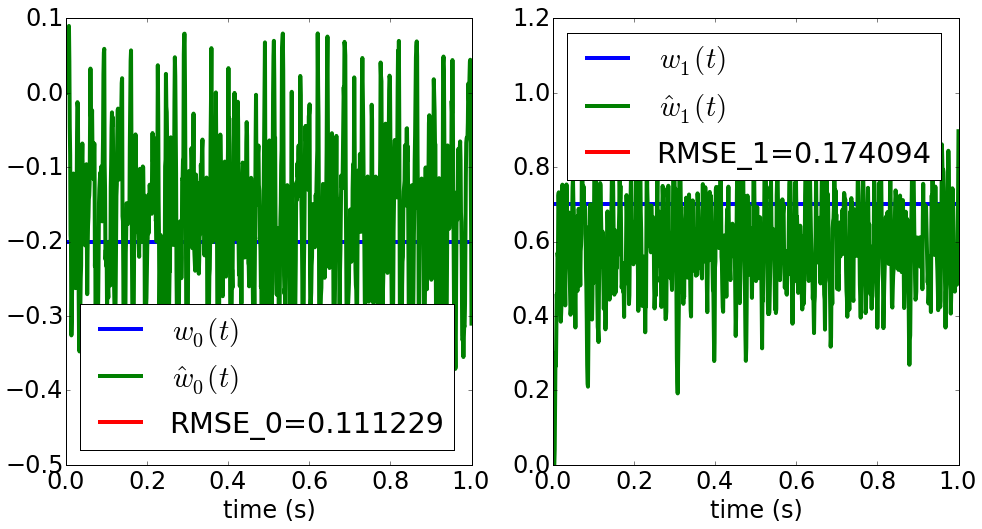

In [15]:
def six_a():

    #parameters
    n_neurons=200
    dimension=2
    a_min=100
    a_max=200
    x_min=-1
    x_max=1
    dx=0.05
    tau_ref=0.002
    tau_rc=0.02
    T=1
    dt=0.001
    n=0
    rms=0.5
    noise=0.1*a_max
    seed=3
    t=np.arange(int(T/dt)+1)*dt

    #set post-synaptic current temporal filter
    tau_synapse=0.005          
    h=t**n*np.exp(-t/tau_synapse)
    h=h/np.sum(h*dt)

    #stimuli
    x_t=np.full((len(t),dimension),[0.5,1])
    y_t=np.full((len(t),dimension),[0.1,0.3])
    z_t=np.full((len(t),dimension),[0.2,0.1])
    q_t=np.full((len(t),dimension),[0.4,-0.2])
    w_t=x_t-3*y_t+2*z_t-2*q_t

    #transforms
    f1=lambda x: x
    f2=lambda y: y
    f3=lambda z: z
    f4=lambda q: q
    f5=lambda w: w

    #ensembles
    n1,spikes1=ensemble_2D(n_neurons,x_min,x_max,dx,a_min,a_max,
                seed,tau_ref,tau_rc,noise,T,dt,stimulus=x_t)
    n2,spikes2=ensemble_2D(n_neurons,x_min,x_max,dx,a_min,a_max,
                seed,tau_ref,tau_rc,noise,T,dt,stimulus=y_t)
    n3,spikes3=ensemble_2D(n_neurons,x_min,x_max,dx,a_min,a_max,
                seed,tau_ref,tau_rc,noise,T,dt,stimulus=z_t)
    n4,spikes4=ensemble_2D(n_neurons,x_min,x_max,dx,a_min,a_max,
                seed,tau_ref,tau_rc,noise,T,dt,stimulus=q_t)

    #decode
    d1=get_rate_decoders(n1,noise,f1)
    d2=get_rate_decoders(n2,noise,f2)
    d3=get_rate_decoders(n3,noise,f3)
    d4=get_rate_decoders(n4,noise,f4)

    #estimate
    f_xhat=get_spike_estimate(spikes1,h,d1)   
    f_yhat=get_spike_estimate(spikes2,h,d2)
    f_zhat=get_spike_estimate(spikes3,h,d3)
    f_qhat=get_spike_estimate(spikes4,h,d4)

    #final transformation and estimate
    feedforward=f_xhat-3*f_yhat+2*f_zhat-2*f_qhat
    n5,spikes5=ensemble_2D(n_neurons,x_min,x_max,dx,a_min,a_max,
                seed,tau_ref,tau_rc,noise,T,dt,stimulus=feedforward)
    d5=get_rate_decoders(n5,noise,f5)
    f_what=get_spike_estimate(spikes5,h,d5)

    #plot signal, transformed signal, and estimate
    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(121)
    ax.plot(t,w_t[:,0], label='$w_0(t)$')#=x(t)-3*y(t)+2*z(t)-2*q(t)$')
    ax.plot(t,f_what[:,0], label='$\hat{w}_0(t)$')
    ax.plot([],label='RMSE_0=%f' %np.sqrt(np.average((w_t[:,0]-f_what[:,0])**2)))
    ax.set_xlabel('time (s)')
    legend=ax.legend(loc='best')
    ax=fig.add_subplot(122)
    ax.plot(t,w_t[:,1], label='$w_1(t)$')#=x(t)-3*y(t)+2*z(t)-2*q(t)$')
    ax.plot(t,f_what[:,1], label='$\hat{w}_1(t)$')
    ax.plot([],label='RMSE_1=%f' %np.sqrt(np.average((w_t[:,1]-f_what[:,1])**2)))
    ax.set_xlabel('time (s)')
    legend=ax.legend(loc='best')
    plt.show()
    
six_a()

#### [0.5 marks] Produce the same plot for $x=[0.5,1], y=[sin(4\pi t),0.3], z=[0.2,0.1], q = [sin(4\pi t),-0.2]$.

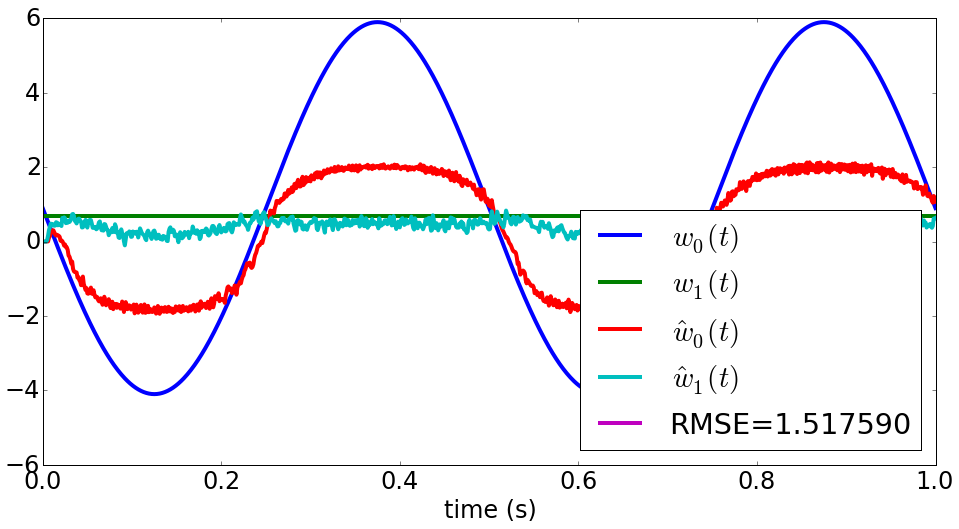

In [16]:
def six_b():

    #parameters
    n_neurons=200
    dimension=2
    a_min=100
    a_max=200
    x_min=-1
    x_max=1
    dx=0.05
    tau_ref=0.002
    tau_rc=0.02
    T=1
    dt=0.001
    n=0
    rms=0.5
    noise=0.1*a_max
    seed=3
    t=np.arange(int(T/dt)+1)*dt

    #set post-synaptic current temporal filter
    tau_synapse=0.005          
    h=t**n*np.exp(-t/tau_synapse)
    h=h/np.sum(h*dt)

    #stimuli
    x_t=np.full((len(t),dimension),[0.5,1])
    y_t=np.vstack([np.sin(4*np.pi*t),0.3*np.cos(0*t)]).T
    z_t=np.full((len(t),dimension),[0.2,0.1])
    q_t=np.vstack([np.sin(4*np.pi*t),-0.2*np.cos(0*t)]).T
    w_t=x_t-3*y_t+2*z_t-2*q_t

    #transforms
    f1=lambda x: x
    f2=lambda y: y
    f3=lambda z: z
    f4=lambda q: q
    f5=lambda w: w

    #ensembles
    n1,spikes1=ensemble_2D(n_neurons,x_min,x_max,dx,a_min,a_max,
                seed,tau_ref,tau_rc,noise,T,dt,stimulus=x_t)
    n2,spikes2=ensemble_2D(n_neurons,x_min,x_max,dx,a_min,a_max,
                seed,tau_ref,tau_rc,noise,T,dt,stimulus=y_t)
    n3,spikes3=ensemble_2D(n_neurons,x_min,x_max,dx,a_min,a_max,
                seed,tau_ref,tau_rc,noise,T,dt,stimulus=z_t)
    n4,spikes4=ensemble_2D(n_neurons,x_min,x_max,dx,a_min,a_max,
                seed,tau_ref,tau_rc,noise,T,dt,stimulus=q_t)

    #decode
    d1=get_rate_decoders(n1,noise,f1)
    d2=get_rate_decoders(n2,noise,f2)
    d3=get_rate_decoders(n3,noise,f3)
    d4=get_rate_decoders(n4,noise,f4)

    #estimate
    f_xhat=get_spike_estimate(spikes1,h,d1)   
    f_yhat=get_spike_estimate(spikes2,h,d2)
    f_zhat=get_spike_estimate(spikes3,h,d3)
    f_qhat=get_spike_estimate(spikes4,h,d4)

    #final transformation and estimate
    feedforward=f_xhat-3*f_yhat+2*f_zhat-2*f_qhat
    n5,spikes5=ensemble_2D(n_neurons,x_min,x_max,dx,a_min,a_max,
                seed,tau_ref,tau_rc,noise,T,dt,stimulus=feedforward)
    d5=get_rate_decoders(n5,noise,f5)
    f_what=get_spike_estimate(spikes5,h,d5)

    #plot signal, transformed signal, and estimate
    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.plot(t,w_t[:,0], label='$w_0(t)$')
    ax.plot(t,w_t[:,1], label='$w_1(t)$')
    ax.plot(t,f_what[:,0], label='$\hat{w}_0(t)$')
    ax.plot(t,f_what[:,1], label='$\hat{w}_1(t)$')
    ax.plot([],label='RMSE=%f' %np.sqrt(np.average((w_t-f_what)**2)))
    ax.set_xlabel('time (s)')
    legend=ax.legend(loc='best')
    plt.show()
    
six_b()

#### [0.5 marks] Describe your results and discuss why and how they stray from the expected answer.

### Discussion

The first dimension of $\hat{w}(t)$ significantly underestimates the actual signal $w(t)$. This is caused by neuron saturation: the maximum value that can be faithfully represented by a neuron is $x_{max}=1$. Beyond this value, the tuning curves of the neurons begin to flatten out, leading to diminishing returns in activity as $x(t)$ increases. This limits the entries in the activities matrix $A$, which in turn limits the decoders $d$ and the magnitude of the final estimate $\hat{w}(t)$. I confirmed this by scaling $w(t)$ and the stimulus fed into the ensemble that calculates $\hat{w}(t)$: dividing by $10$ allows $\hat{w}(t)$ to closely match the first dimension of $w(t)$, while multiplying by $10$ still leaves $\hat{w}(t)$ varying from $-2$ to $2$. The exact value at which the ensemble saturates is a function of the distribution of the neurons' x-intercepts, maximum firing rates, $\alpha$s, $J^{bias}$s.

The second dimension of $\hat{w}(t)$ does not accurately represent the line; it deviates when the value represented in the first dimension passes beyond the optimum value $x_{max}=1$. In other words, when the neurons oversaturate due to high values in the first dimension, the estimate in the second dimension gets systematically worse. In this case, oversaturation causes underestimation of the second dimension, but this varies with the seed. The reason that the estimate is consistently below (or above) the signal value can be explained as follows. Consider the tuning curve for each neuron, extended beyond $x_{max}$ to some value $x_{signal}$. Neurons with large $\alpha$ will have a proportionally higher firing rates at $x_{signal}$ than those with low $\alpha$. The decoders have already been calculated with the assumption that any $A$ matrix corresponds to $x$ within the normal range. When decoding $\hat{w}(t)$, the high activity neurons will contribute more than other neurons, and construct a signal that favors the dimensions in which their decoders point, leading to a systematic over- or underestimation of the true signal.